In [11]:
# !pip3 install --upgrade pip
# %pip install cirq
# %pip install cirq_google

In [26]:
import cirq
import cirq_google
import networkx as nx
import matplotlib.pyplot as plt
import sympy

In [8]:
# Using named qubits can be useful for abstract algorithms
# as well as algorithms not yet mapped onto hardware.
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Line qubits can be created individually
q3 = cirq.LineQubit(3)

# Or created in a range
# This will create LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# Grid Qubits can also be referenced individually
q4_5 = cirq.GridQubit(4, 5)

# Or created in bulk in a square
# This will create 16 qubits from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)

In [14]:
print(cirq_google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

In [15]:
# Example gates
cnot_gate = cirq.CNOT
pauli_z = cirq.Z

# Use exponentiation to get square root gates.
sqrt_x_gate = cirq.X**0.5

# Some gates can also take parameters
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

# Create two qubits at once, in a line.
q0, q1 = cirq.LineQubit.range(2)

# Example operations
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0, q1)
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

# You can also use the gates you specified earlier.
cnot_op = cnot_gate(q0, q1)
pauli_z_op = pauli_z(q0)
sqrt_x_op = sqrt_x_gate(q0)
sqrt_sqrt_y_op = sqrt_sqrt_y(q0)

In [17]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.Z(qubits[2]))
print(circuit)

0: ───H───

1: ───H───

2: ───Z───


In [18]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


In [19]:
print(cirq.Circuit(cirq.SWAP(q, q + 1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


In [20]:
# Creates each gate in a separate moment by passing an iterable of Moments instead of Operations.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


In [21]:
# Create some qubits.
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# Create operations using the Sycamore gate, which is supported by the Sycamore device.
# However, create operations for both adjacent and non-adjacent qubit pairs.
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# A working circuit for the Sycamore device raises no issues.
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# A circuit using invalid operations.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(5, 6), cirq.GridQubit(4, 5)).


In [22]:
# Create a circuit to generate a Bell State:
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

# Initialize Simulator
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(bell_circuit)
print(results)

# For sampling, we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# Sample the circuit
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


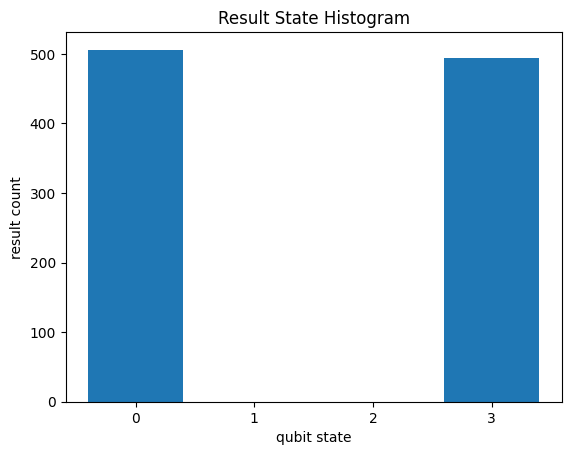

In [24]:
cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

Counter({0: 506, 3: 494})


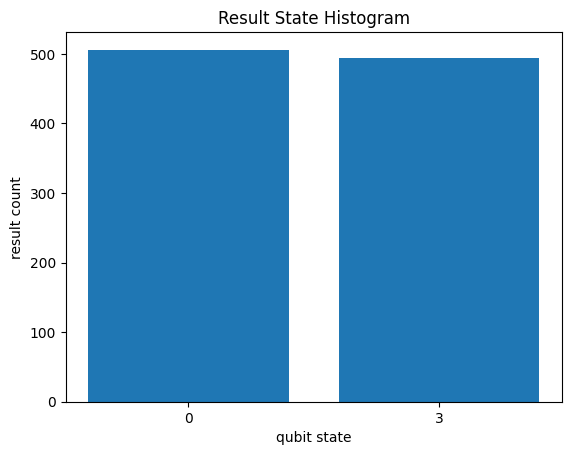

In [25]:
# Pull of histogram counts from the result data structure
counts = samples.histogram(key='result')
print(counts)

# Graph the histogram counts instead of the results
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

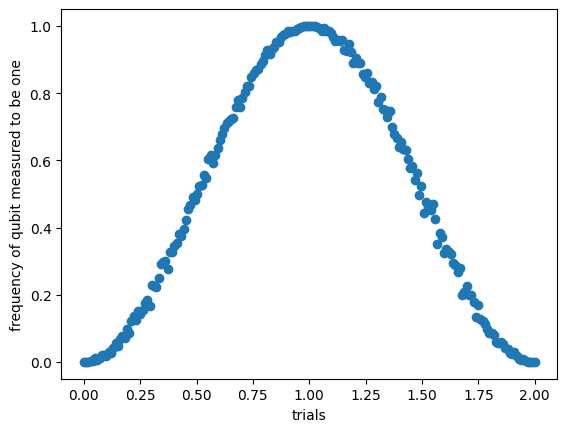

In [27]:
# Perform an X gate with variable exponent
q = cirq.GridQubit(1, 1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'), cirq.measure(q, key='m'))

# Sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# Simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t', 'p', data={'t': x_data, 'p': y_data})
plt.xlabel("trials")
plt.ylabel("frequency of qubit measured to be one")
plt.show()

In [28]:
print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


In [29]:
print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(global_shift=-0.25).on(cirq.LineQubit(0))]


In [30]:
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))

0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


In [31]:
q = cirq.GridQubit(1, 1)
c = cirq.Circuit(cirq.X(q) ** 0.25, cirq.Y(q) ** 0.25, cirq.Z(q) ** 0.25)
print(c)
c = cirq.merge_single_qubit_gates_to_phxz(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
(1, 1): ───PhXZ(a=0.304,x=0.333,z=0.142)───
